In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as mse

In [167]:
df_competitors = pd.read_parquet("../data/df_competitors.parquet")
df_transactions = pd.read_parquet("../data/df_end_transaction_ma.parquet")

Filter amount < 0:

In [168]:
df_transactions = df_transactions[df_transactions["amount"] > 0]

In [169]:
df_transactions.shape

(699477, 5)

In [170]:
X = df_transactions.drop('price', axis=1)
y = df_transactions['price']

In [171]:
X.shape, y.shape

((699477, 4), (699477,))

Немного преобразуем данные. Дату буду преобразовывать: DateTime текущая - min(DateTime) 

In [172]:
# one hot
X = pd.get_dummies(X, columns=['product', 'place'])

X['year'] = X['datetime'].dt.year
X['month'] = X['datetime'].dt.month
X['day'] = X['datetime'].dt.day

In [183]:
X.shape, y.shape

((699477, 10), (699477,))

In [184]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [185]:
X_train.head()

,amount,datetime,product_Целебные травы,product_Эльфийская пыльца,product_Эстус,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,place_Фалькония
444764,1.730538,1043104,False,True,False,False,False,True,False,False
552367,0.019141,432770,False,True,False,False,False,False,True,False
329392,1.283277,146282,False,True,False,False,False,True,False,False
422343,1.684545,876100,False,True,False,False,False,True,False,False
408176,0.399705,753304,True,False,False,False,False,True,False,False


Модель регрессии:

In [194]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test), reg.coef_

(0.8812319989253479,
 array([-4.61468789e-04,  6.68442173e-06, -2.60480358e+00,  4.52632004e+00,
        -1.92151647e+00, -1.76970476e+00,  3.72882396e+00,  3.39923510e+00,
        -3.33666462e+00, -2.02168968e+00]))

Оценим r2_score:

In [188]:
y_pred = reg.predict(X_test)
r2_score(y_test, y_pred)

0.8812319989253479

Посмотрим ансамблирование 

In [191]:
# Random forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [192]:
r2_score(y_test, y_pred)

0.9999976193155031

In [200]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

mae_scores = []
mse_scores = []

for n_estimators in range(1, 20):
	model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
	model.fit(X_train, y_train)
	y_pred = model.predict(X_test)
	_mae = mean_absolute_error(y_test, y_pred)
	_mse = mean_squared_error(y_test, y_pred)
	mae_scores.append(_mae)
	mse_scores.append(_mse)

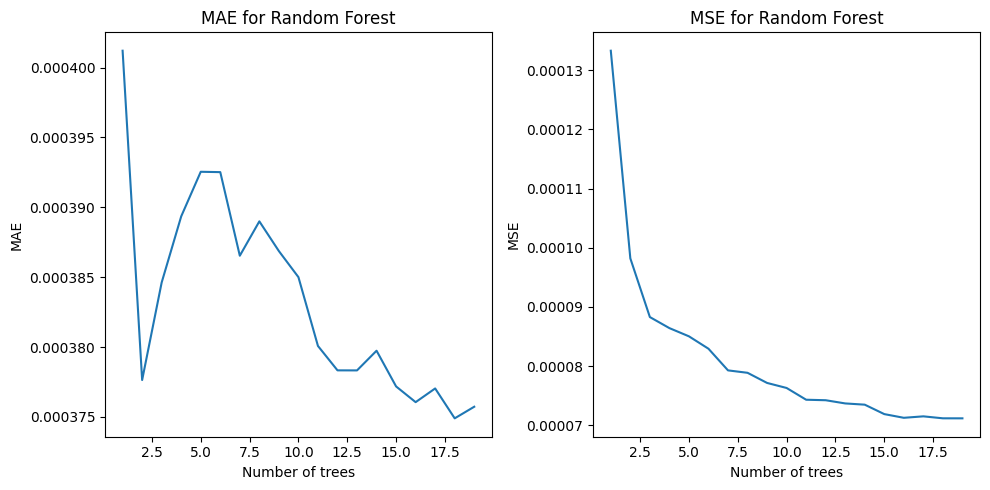

In [203]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 20), mae_scores)
plt.title('MAE for Random Forest')
plt.xlabel('Number of trees')
plt.ylabel('MAE')

plt.subplot(1, 2, 2)
plt.plot(range(1, 20), mse_scores)
plt.title('MSE for Random Forest')
plt.xlabel('Number of trees')
plt.ylabel('MSE')

plt.tight_layout()
plt.show()

In [193]:
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)
vr = VotingRegressor(
  estimators=[('lr', lr), ('rf', rf)]
)

vr.fit(X_train, y_train)

y_pred = vr.predict(X_test)

In [196]:
r2_score(y_test, y_pred)

0.9703075418902548